In [1]:
import branca
import clusters_builder
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
import importlib
import json
import numpy as np
import pandas as pd
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import requests
import selenium.webdriver
from matplotlib import pyplot as plt

In [2]:
def validate_country_name(df, col_name):
    # according to https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json
    df.loc[df[col_name]=='US',col_name]='United States of America'
    df.loc[df[col_name]=='Congo (Kinshasa)',col_name]='Republic of the Congo'
    df.loc[df[col_name]=='Congo (Brazzaville)',col_name]='Democratic Republic of the Congo'
    df.loc[df[col_name]=='Serbia',col_name]='Republic of Serbia'
    df.loc[df[col_name]=='Czechia',col_name]='Czech Republic'
    df.loc[df[col_name]=='Taiwan*',col_name]='Taiwan'
    df.loc[df[col_name]=='North Macedonia',col_name]='Macedonia'

In [3]:
def my_color_function(feature, df_dict, colorscale):
    if not feature['properties']['ADMIN']  in df_dict:
        return '#ffffff'
    return colorscale(df_dict[feature['properties']['ADMIN']])

In [4]:
def create_colorscale(n):
    colorscale=branca.colormap.linear.YlOrRd_09.scale(0,n)
    colorscale=colorscale.to_step(index=[i for i in range(n+1)])
    colorscale.caption='Cluster id'
    return colorscale

In [5]:
def get_geo_json(clean_data):
    country_shapes='https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson'
    geo_json=json.loads(requests.get(country_shapes).text)
    for i in range(len(geo_json['features'])):
        name=geo_json['features'][i]['properties']['ADMIN']
        for column_name in ['New cases', 'New deaths', 'New recovered']:
            geo_json['features'][i]['properties'][column_name]=0
            if name in clean_data['Country/Region'].values:
                geo_json['features'][i]['properties'][column_name]=\
                int(clean_data[clean_data['Country/Region']==name][column_name].values[0])
        
    return geo_json

In [6]:
def create_map(geo_json,df_dict, n, date):
    colorscale=create_colorscale(n)
    m=folium.Map(tiles="cartodbpositron", zoom_start=2,location=[40., 10.],zoom_control=False, max_bounds=True)
    folium.GeoJson(
        geo_json,
        style_function=lambda feature: {
            'fillColor': my_color_function(feature, df_dict, colorscale),
            'fillOpacity': 1,
            'color' : 'black',
            'weight' : 1,
            'dashArray' : '1,1'
            },
        name='COVID CLUSTERS',
        tooltip=folium.features.GeoJsonTooltip(
            fields=['ADMIN', 'New cases', 'New deaths', 'New recovered'],
            aliases=['Country', 'New cases', 'New deaths', 'New recovered'])
        ).add_to(m)
    m.add_child(colorscale)
    
    
    title_html = '''
                 <h3 align="center" style="font-size:12px"><b>{}</b></h3>
                 '''.format(date)   
    m.get_root().html.add_child(folium.Element(title_html))
    
    m.save('covid.html')

In [7]:
def save_as_png(date):
    driver = selenium.webdriver.Chrome()
    driver.get("file:///C:/Users/DELL/Covid_clusters/covid.html")
    driver.save_screenshot('pictures.v2/'+date+'.png')
    driver.quit()

In [8]:
def save_map(builder,date):
    clusters=builder.get_clusters(date)
    print([len(x) for x in clusters])
    print([x for x in clusters if len(x)<10])
    clean_data=builder.data_all_days.loc[builder.data_all_days['Date']==date].copy()
    n=len(clusters)
    
    rows=[[country,i+1] for i in range(n) for country in clusters[i]]
    clusters_dict={_id: rows[_id] for _id in range(builder.n_vert) }
    
    df=pd.DataFrame.from_dict(clusters_dict,orient='index', columns=['CountryName', 'Cluster'])

    validate_country_name(df,'CountryName')
    validate_country_name(clean_data, 'Country/Region')
    df_dict=df.set_index('CountryName')['Cluster']
    geo_json=get_geo_json(clean_data)
    create_map(geo_json, df_dict, n, date)
    save_as_png(date)

[179, 1, 3, 1, 1, 1, 1]


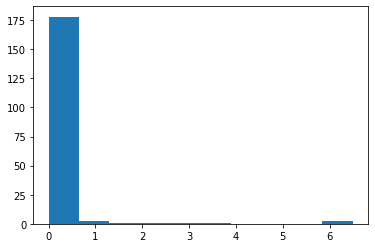

In [9]:
importlib.reload(clusters_builder)
n=5
builder=clusters_builder.Clusters_Builder()
date='2020-06-11'
weights, clusters=builder.get_clusters(date)
print([len(x) for x in clusters])
plt.hist(weights)
plt.show()
#save_map(builder, date)

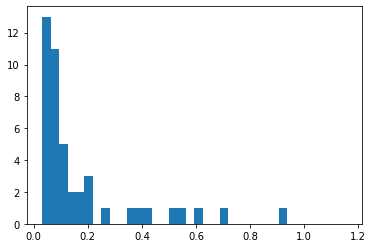

In [15]:
plt.hist(weights, bins=[0.125*i/4 for i in range(1,38)])
plt.show()

In [37]:
np.mean(weights)

0.20005774347750788

In [41]:
colorscale=branca.colormap.StepColormap(colors={'yellow','red'}, vmin=0, vmax=5)
print(colorscale(0),colorscale(1), colorscale(2), colorscale(3))


#ff0000ff #ff0000ff #ff0000ff #ffff00ff


In [9]:
importlib.reload(clusters_builder)
n=5
builder=clusters_builder.Clusters_Builder(n_clusters=n)
dates=sorted(list(set(builder.data_all_days['Date'].values)))
for date in dates:
    #if date<'2020-03-15':
     #   continue
    save_map(builder, date)
    print(date)
    if date>='2020-03-14':
        break

[180, 4, 1, 1, 1]
2020-01-22
[3, 180, 2, 1, 1]
2020-01-23
[180, 1, 1, 4, 1]
2020-01-24
[180, 2, 3, 1, 1]
2020-01-25
[182, 1, 1, 2, 1]
2020-01-26
[179, 1, 1, 5, 1]
2020-01-27
[181, 1, 3, 1, 1]
2020-01-28
[180, 1, 3, 2, 1]
2020-01-29
[183, 1, 1, 1, 1]
2020-01-30
[183, 1, 1, 1, 1]
2020-01-31
[181, 3, 1, 1, 1]
2020-02-01
[180, 1, 4, 1, 1]
2020-02-02
[180, 2, 3, 1, 1]
2020-02-03
[178, 4, 2, 2, 1]
2020-02-04
[180, 4, 1, 1, 1]
2020-02-05
[180, 4, 1, 1, 1]
2020-02-06
[1, 182, 1, 2, 1]
2020-02-07
[1, 183, 1, 1, 1]
2020-02-08
[1, 183, 1, 1, 1]
2020-02-09
[180, 4, 1, 1, 1]
2020-02-10
[1, 182, 2, 1, 1]
2020-02-11
[1, 176, 8, 1, 1]
2020-02-12
[1, 180, 4, 1, 1]
2020-02-13
[180, 4, 1, 1, 1]
2020-02-14
[182, 1, 2, 1, 1]
2020-02-15
[1, 180, 1, 4, 1]
2020-02-16
[180, 4, 1, 1, 1]
2020-02-17
[180, 1, 4, 1, 1]
2020-02-18
[180, 4, 1, 1, 1]
2020-02-19
[180, 4, 1, 1, 1]
2020-02-20
[180, 3, 1, 2, 1]
2020-02-21
[180, 4, 1, 1, 1]
2020-02-22
[180, 1, 1, 4, 1]
2020-02-23
[182, 2, 1, 1, 1]
2020-02-24
[180, 4, 1, 1,

# TESTING

In [91]:
clusters=builder.get_clusters('2020-02-01')

187
built edge list
have clusters


In [97]:
date='2020-02-01'
clean_data=builder.data_all_days.loc[builder.data_all_days['Date']==date].copy()
clusters=sorted(clusters, key=lambda my_set: clean_data[clean_data['Country/Region'].isin(my_set)]['New cases'].mean())

In [1]:
#clusters_dict={_id: rows[_id] for _id in range(builder.n_vert) }

In [3]:
import numpy as np
l=np.array([1,3,4])
np.mean(l)

2.6666666666666665

In [4]:
np.sum(l>2)

2

In [5]:
l[-1]

4